## <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Domain: Face Mask Segmentation

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Problem Description:
<font color=darkblue>
The task is to predict the mask around the face in a given image. The goal is to build a Face Mask Segmentation model using U-Net as architecture which includes building a face detector to locate the position of a face in an image.
</font> 

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Dataset:
<font color=darkblue>WIDER Face Dataset
<br>
WIDER FACE dataset is a Face Mask Segmentation benchmark dataset, of which images are selected from the publicly available WIDER dataset. This data have 32,203 images and 393,703 faces are labeled with a high degree of variability in scale, pose and occlusion as depicted in the sample images.
<br>
In this project, we are using 409 images and around 1000 faces for ease of computation.
<br>
We will be using transfer learning on an already trained model to build our segmenter. We will perform transfer learning on the MobileNet model which is already trained to perform image segmentation. We will need to train the last 6-7 layers and freeze the remaining layers to train the model for face mask segmentation. To be able to train the MobileNet model for face mask segmentation, we will be using the WIDER FACE dataset for various images with a single face and multiple faces. The output of the model is the face mask segmented data which masks the face in an image. We learn to build a face mask segmentation model using Keras supported by Tensorflow.
/font> 

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Context:
<font color=darkblue>
We will be using transfer learning on an already trained model. We will use the MobileNet model which is already trained to detect the face attributes. We will need to train the last 6-7 layers and freeze the remaining layers to train the model for predicting the mask on the face. To be able to train the MobileNet model, we will be using the WIDER FACE dataset for various images with a single face and multiple faces.
</font>

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Objective:
<font color=darkblue>In this problem, we use "Transfer Learning" of an Image Segmentation model to detect any object according to the problem in hand. Here, we are particularly interested in segmenting faces in a given image</font>

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Import the necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

import tensorflow

In [2]:
print('Tensorflow Version : ', tensorflow.__version__)
print('Numpy Version : ', np.__version__)
print('Pandas Version : ', pd.__version__)
print('Matplotlib Version : ', matplotlib.__version__)


Tensorflow Version :  2.4.0
Numpy Version :  1.19.4
Pandas Version :  1.1.3
Matplotlib Version :  3.2.2


#### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Observation :
<font color=darkblue>
<ul>
<li>Tensorflow Version :  2.3.1</li>
<li>Numpy Version :  1.18.5</li>
<li>Pandas Version :  1.1.3</li>
<li>Matplotlib Version :  3.2.2</li>
</ul>
</font>

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Setting Options

In [3]:
%matplotlib inline


### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Load the dataset given in form .npy format :
<font color=darkblue>
This file contains images with details of bounding boxes
<ul>
</ul>
</font>

In [4]:
image_data = np.load('images.npy', allow_pickle=True)

In [5]:
image_data.shape

(409, 2)

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Check samples from the loaded "images.npy" file :
<font color=darkblue>
Hint: print data[10][1]
<ul>
</ul>
</font>

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">
<font color=darkblue>
Sample Image
<ul>
</ul>
</font>

In [6]:
print(image_data[10][0])

[[[2 2 2]
  [2 2 2]
  [2 2 2]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[2 2 2]
  [2 2 2]
  [2 2 2]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[2 2 2]
  [2 2 2]
  [2 2 2]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [5 5 5]
  [6 6 6]
  [6 6 6]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [5 5 5]
  [6 6 6]
  [6 6 6]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [5 5 5]
  [5 5 5]
  [5 5 5]]]


### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">
<font color=darkblue>
Sample Mask
<ul>
</ul>
</font>

In [7]:
print(image_data[10][1])

[{'label': ['Face'], 'notes': '', 'points': [{'x': 0.48, 'y': 0.10385756676557864}, {'x': 0.7716666666666666, 'y': 0.6795252225519288}], 'imageWidth': 600, 'imageHeight': 337}]


### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Set image dimensions :
<font color=darkblue>
Initialize image height, image width with value: 224 
<ul>
</ul>
</font>


In [8]:
ALPHA = 1 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower

IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

HEIGHT_CELLS = 28
WIDTH_CELLS = 28

IMAGE_SIZE = 224


### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Create features and labels :
<font color=darkblue>
<ul>
<li>Here feature is the image</li>
<li>The label is the mask</li>
<li>Images will be stored in "X" array</li>
<li>Masks will be stored in "masks" array</li>
</ul>
</font>

In [9]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(image_data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(image_data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(image_data.shape[0]):
    img = image_data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in image_data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Split the data into training and testing :
<font color=darkblue>
<ul>
<li>400 images in training</li>
<li>9 images in testing data</li>
</ul>
</font>

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, masks, test_size=0.02, random_state=100)


### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">
<font color=darkblue>
Training data
<ul>
</ul>
</font>

In [11]:
X_train.shape, y_train.shape

((400, 224, 224, 3), (400, 224, 224))

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">
<font color=darkblue>
Testing data
<ul>
</ul>
</font>

In [12]:
X_valid.shape, y_valid.shape

((9, 224, 224, 3), (9, 224, 224))

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Print a sample training image, image array and its mask :
<font color=darkblue>
Print the image and image array
<ul>
</ul>
</font>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


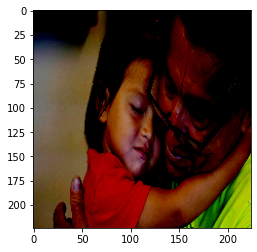

In [13]:
plt.imshow(X_train[200])

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">
<font color=darkblue>
Print the mask
<ul>
</ul>
</font>

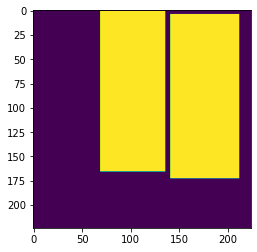

In [14]:
plt.imshow(y_train[200])

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Create the model :
<font color=darkblue>
Add MobileNet as model with below parameter values
<ul>
<li><b>input_shape :</b> IMAGE_HEIGHT, IMAGE_WIDTH, 3</li>
<li><b>include_top :</b> False</li>
<li><b>alpha :</b> 1.0</li>
<li><b>weights :</b> "imagenet"</li>
</ul>
Add UNET architecture layers
<ul>
<li>This is the trickiest part of the project, you need to research and implement it correctly</li>
</ul>
</font>

In [15]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from tensorflow.keras.models import Model

def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, 
                      alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_1_relu").output
    block2 = model.get_layer("conv_pw_3_relu").output
    block3 = model.get_layer("conv_pw_5_relu").output
    block4 = model.get_layer("conv_pw_11_relu").output
    block5 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block5), block4])
    x = Concatenate()([UpSampling2D()(x), block3])
    x = Concatenate()([UpSampling2D()(x), block2])
    x = Concatenate()([UpSampling2D()(x), block1])
    x = UpSampling2D()(x)

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(x)

    return Model(inputs=model.input, outputs=x)

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Call the create_model function :
<font color=darkblue>
Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)
<ul>
</ul>
</font>

In [16]:
model = create_model(False)

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Print model summary :
<font color=darkblue>
<ul>
</ul>
</font>

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Define dice coefficient function :
<font color=darkblue>
Create a function to calculate dice coefficient
<ul>
</ul>
</font>

In [18]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Define loss function :
<font color=darkblue>
<ul>
</ul>
</font>

In [19]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Compile the model :
<font color=darkblue>
Complie the model using below parameters
<ul>
<li><b>loss :</b> use the loss function defined above</li>
<li><b>optimizers :</b> use Adam optimizer</li>
<li><b>metrics :</b> use dice_coefficient function defined above</li>
</ul>
</font>

In [20]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Define callbacks :
<font color=darkblue>
<ul>
<li>Use ModelCheckpoint</li>
<li>Use EarlyStopping</li>
<li>Use ReduceLROnPlateau</li>
</ul>
</font>

In [21]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, 
                             save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

callbacks = (checkpoint, stop, reduce_lr)

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Fit the model :
<font color=darkblue>
Fit the model using below parameters
<ul>
<li><b>epochs :</b> you can decide</li>
<li><b>batch_size :</b> 1</li>
<li><b>callbacks :</b> use the callbacks defined above</li>
</ul>
</font>

In [22]:
model.fit(X_train, y_train, validation_data = (X_valid, y_valid), epochs=40, batch_size=1, 
          verbose=1, callbacks=callbacks)


Epoch 1/40
400/400 [==============================] - 249s 615ms/step - loss: 2.6321 - dice_coefficient: 0.2086 - val_loss: 1.3673 - val_dice_coefficient: 0.3573

Epoch 00001: val_loss improved from inf to 1.36729, saving model to model-1.37.h5
Epoch 2/40
400/400 [==============================] - 235s 588ms/step - loss: 1.3208 - dice_coefficient: 0.4115 - val_loss: 1.0612 - val_dice_coefficient: 0.4619

Epoch 00002: val_loss improved from 1.36729 to 1.06119, saving model to model-1.06.h5
Epoch 3/40
400/400 [==============================] - 234s 585ms/step - loss: 1.1209 - dice_coefficient: 0.4739 - val_loss: 0.9530 - val_dice_coefficient: 0.5083

Epoch 00003: val_loss improved from 1.06119 to 0.95304, saving model to model-0.95.h5
Epoch 4/40
400/400 [==============================] - 235s 587ms/step - loss: 1.0064 - dice_coefficient: 0.5185 - val_loss: 0.9129 - val_dice_coefficient: 0.5334

Epoch 00004: val_loss improved from 0.95304 to 0.91295, saving model to model-0.91.h5
Epoch 5/

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Evaluate the model :
<font color=darkblue>
</font>

In [23]:
model.evaluate(X_valid, y_valid, verbose=1)

1/1 [==============================] - 3s 3s/step - loss: 0.7062 - dice_coefficient: 0.6397


[0.7061623334884644, 0.6397271156311035]

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Get the predicted mask for a test image :
<font color=darkblue>
Show the test image
<ul>
</ul>
</font>

In [24]:
image_file = 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


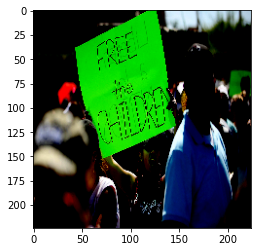

In [25]:
plt.imshow(X_valid[image_file])

###### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">
<font color=darkblue>
Show original mask for test image
<ul>
</ul>
</font>

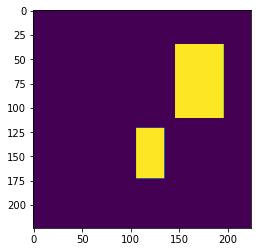

In [26]:
plt.imshow(y_valid[image_file])

###### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">
<font color=darkblue>
Predict the mask on the test image
<ul>
</ul>
</font>

In [27]:
#Plot a sample
def plot_sample(X, preds):
    fig, ax = plt.subplots(1, 2, figsize=(8, 5))
    ax[0].imshow(X)
    ax[0].set_title('Validation')

    ax[1].imshow(preds)
    ax[1].set_title('Predicted')


1/1 [==============================] - 2s 2s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


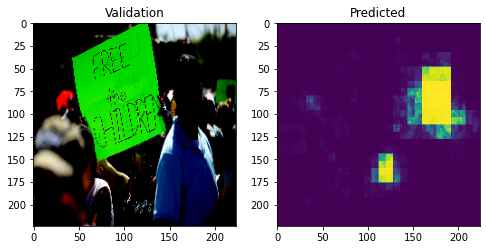

In [28]:
pred_val = model.predict(X_valid, verbose=1)
plot_sample(X_valid[0], pred_val[0])

### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Impose the mask on the test image :
<font color=darkblue>
<ul>
    <li>In imshow use the alpha parameter and set it to greater than 0.5</li>
</ul>
</font>

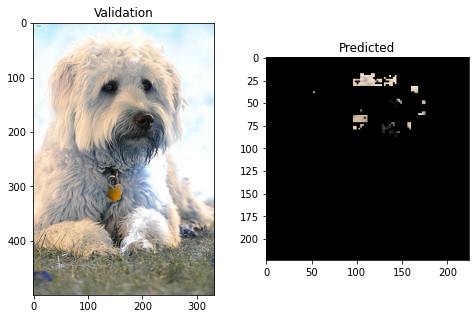

In [29]:
filename = 'image_12.jpg'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plot_sample(unscaled, out_image)


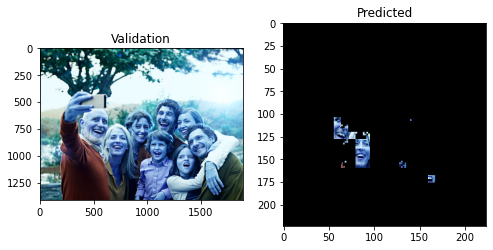

In [30]:
filename = 'image_2.jpg'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plot_sample(unscaled, out_image)


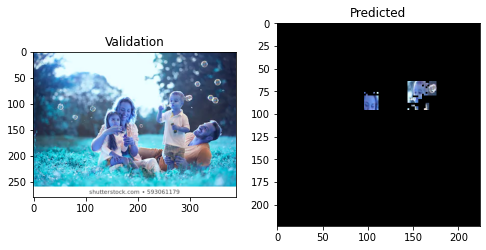

In [31]:
filename = 'image_6.jpg'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plot_sample(unscaled, out_image)


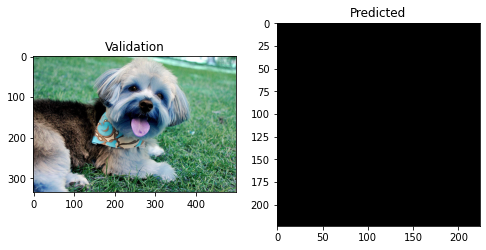

In [32]:
filename = 'image_13.jpg'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plot_sample(unscaled, out_image)


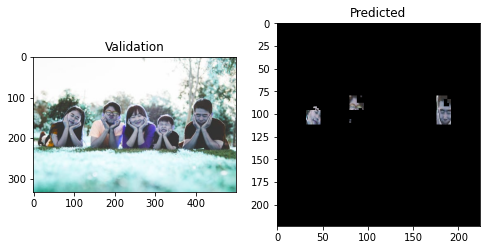

In [33]:
filename = 'image_4.jpg'

unscaled = cv2.imread(filename)
image = cv2.resize(unscaled, (IMAGE_WIDTH, IMAGE_HEIGHT))
feat_scaled = preprocess_input(np.array(image, dtype=np.float32))

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([feat_scaled]))[0] > 0.5), (IMAGE_WIDTH,IMAGE_HEIGHT))

image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plot_sample(unscaled, out_image)


#### <span style="font-family: Arial; font-weight:bold;font-size:1.25em;color:#00b3e5;">Conclusion :
<font color=darkblue>
We Loaded the dataset given in form .npy format. It had 409 images. Set the image size to 224. Created features and labels. We then split data as 400 images for train and 9 images for test/validation dataset. Reviewed some images and masks. Created a MobileNet model, defined deice coefficient and loss function and complied the model. Defined callbacks using ModelCheckPoint, EarlyStopping and ReduceLROnPlateau. Fitted the model with 40 Epochs and batch_size as 1. Evalutead the model by predicting the mask of test image.
</font>